In [1]:
import numpy as np
import pandas as pd

from scipy.stats import mode
from scipy.stats import skew
from scipy.stats import kurtosis

import random
random.seed(42)

stride = 25
window = 150

def extractFeatures(df):
    l = 0
    r = 3
    f = []
    for i in range(0,4):
        temp = df.iloc[:,l:r]
        f1 = list(temp.mean())
        
        C = temp.cov()
        f2 = []
        f2 += list(C.iloc[0,1:3])
        f2 += list(C.iloc[1,[0,2]])
        f2 += list(C.iloc[2,0:2])
        
        f3 = list(temp.apply(skew, axis = 0))
        f4 = list(temp.apply(kurtosis, axis = 0))
        
        f5 = list(temp.max())
        f6 = list(temp.min())
        
        l += 3
        r += 3
        ff = f1 + f2 + f3 + f4 + f5 + f6
        f += ff
    return f

def extractForSession(observations, labels):
    X = []
    y = []

    for i in range(window, len(observations), stride):
        X.append(extractFeatures(observations.iloc[i-150:i,])) 
        label = mode(labels.iloc[i-150:i,])[0]
        y.append(label[0][0])
    
    return pd.DataFrame(X), pd.DataFrame(y)

def loadSession(session_name):
    datapath = 'Training Data/' + session_name + '/'
    t_df = pd.read_csv(datapath + 'time.txt', sep = '\s+', header = None)
    arm = pd.read_csv(datapath + 'armIMU.txt',sep = '\s+', header = None)
    wrist = pd.read_csv(datapath + 'wristIMU.txt', sep = '\s+',header = None)
    labels = pd.read_csv(datapath + 'detection.txt', sep = '\s+',header = None)
    observations = pd.concat([arm, wrist], axis = 1)
    return observations, labels

In [2]:
session_ids = ['Session01', 'Session05', 'Session06', 'Session07', 'Session12', 'Session13']
random.shuffle(session_ids)

training = session_ids[0:-2]
validation = session_ids[-2:]


def getData(sessions):
    observations = []
    labels = []

    for session in sessions:
        raw_X, raw_y = loadSession(session)
        X, y = extractForSession(raw_X, raw_y)
        observations.append(X)
        labels.append(y)

    X = pd.concat(observations)
    y = pd.concat(labels)
    
    return X, np.array(y[[0]]).ravel()

X_train, y_train = getData(training)
X_val, y_val = getData(validation)

In [3]:
X_train.shape

(26045, 84)

In [4]:
X_val.shape

(10913, 84)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import GridSearchCV
from hypopt import GridSearch

# # Training the model
# model.fit(X_train, y_train) 

# n_estimators = [10,15,20]
# max_depths = [5,10,15]
# criterions = ['gini','entropy']

# accuracy_scores = {}
# other_scores = {}

# for n_estimator in n_estimators:
#     for max_depth in max_depths:
#         for criterion in criterions:
#             model = RandomForestClassifier(class_weight = 'balanced', 
#                                            n_estimators = n_estimator, 
#                                            max_depth = max_depth, 
#                                            criterion = criterion)
#             model.fit(X_train, y_train)
#             y_pred = model.predict(X_val)
#             key = 'n_estimator - {} max_depth - {} criterion - {}'.format(n_estimator, max_depth, criterion)
#             accuracy_scores[key] = accuracy_score(y_pred, y_val)
#             other_scores[key] = precision_recall_fscore_support(y_pred, y_val)
            
            
model = RandomForestClassifier(class_weight = 'balanced', n_estimators = 15, max_depth = 10, criterion = 'entropy')
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [ ]:
accuracy_scores

In [ ]:
max(accuracy_scores.items(), key=operator.itemgetter(1))[0]

In [ ]:
other_scores

0.8956060159245061


No handles with labels found to put in legend.
No handles with labels found to put in legend.


CSV Saved


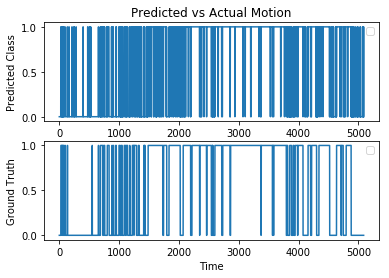

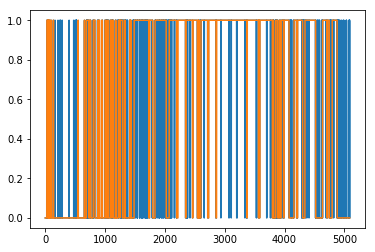

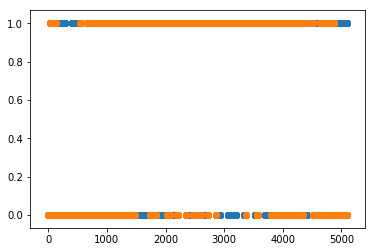

No handles with labels found to put in legend.
No handles with labels found to put in legend.


0.845945945945946
CSV Saved


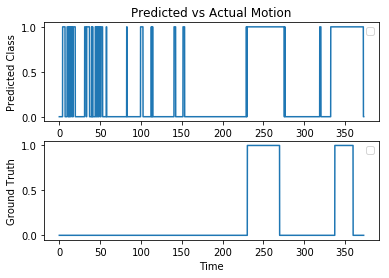

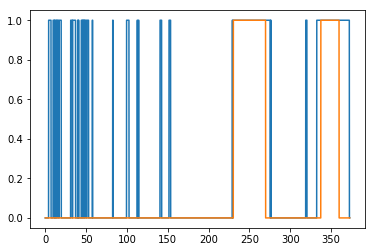

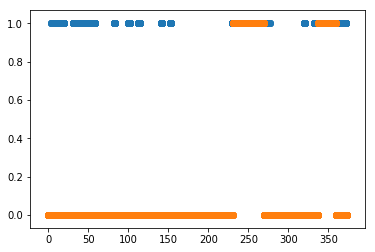

<Figure size 432x288 with 0 Axes>

In [13]:
def createCSV(session, y, obs):
    result = np.zeros(obs)
    idx = 0
    for label in y:
        for j in range(0, window):
            result[idx + j] = label
        idx += 25
    np.savetxt("Training Data/" + session + "/prediction.txt", result, delimiter=",")
    print("CSV Saved")
    return result

def loadTestSession(session_name):
    datapath = 'Test Data 1/' + session_name + '/'
    t_df = pd.read_csv(datapath + 'time.txt', sep = '\s+', header = None)
    arm = pd.read_csv(datapath + 'armIMU.txt',sep = '\s+', header = None)
    wrist = pd.read_csv(datapath + 'wristIMU.txt', sep = '\s+',header = None)
    observations = pd.concat([arm, wrist], axis = 1)
    return observations

def extractForTestSession(observations, labels):
    X = []
    for i in range(window, len(observations), stride):
        X.append(extractFeatures(observations.iloc[i-150:i,])) 

    return pd.DataFrame(X)

import matplotlib.pyplot as plt

test = ['Session02', 'Session03', 'Session15', 'Session16']

for session in validation:
    raw_X_test, raw_y_test = loadSession(session)
    X_test, y_test= extractForSession(raw_X_test, raw_y_test)
    # Make predictions on test data
    y_pred = model.predict(X_test)
    
    print (accuracy_score(y_pred, y_test))
    output = createCSV(session, y_pred, len(raw_X_test))
    
    datapath = 'Training Data/' + session + '/'
    x_axis = pd.read_csv(datapath + 'time.txt', sep = '\s+', header = None) 
    
    plt.subplot(2, 1, 1)
    plt.plot(x_axis, output)
    plt.ylabel('Predicted Class')
    plt.title('Predicted vs Actual Motion')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(x_axis, raw_y_test)
    plt.ylabel('Ground Truth')
    plt.xlabel('Time')
    plt.legend()
    
    plt.savefig('{}.png'.format(session))
    plt.show()
    plt.clf()
    
    plt.plot(x_axis, output)
    plt.plot(x_axis, raw_y_test)
    plt.savefig('line-{}.png'.format(session))
    plt.show()
    plt.clf()
    
    plt.scatter(x_axis, output)
    plt.scatter(x_axis, raw_y_test)
    plt.savefig('line-{}.png'.format(session))
    plt.show()
    plt.clf()

In [ ]:
len(detected)